# Deep Learning 第9回:パラメータの自動最適化

## 今回の目標
学習におけるパラメータについて自動最適化される仕組みを実装していく。  
今回は学習率と重み初期値。

## 学習率の最適化

### 確率的勾配降下法(SGD)

最適パラメータを見つけるためにこれまで使ってきたのがSGD

1. パラメータの勾配（微分）を求める
2. パラメータを勾配方向に更新する
3. 1,2を繰り返して徐々にパラメータを最適に近づける

$ W\leftarrow W-\eta \frac { \partial L }{ \partial W } $

In [61]:
class SGD:
    def __init__(self, lr=0.05):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### デメリット
場合によってはギザギザとした経路を通り、効率的に探索を行うことができない。

### Momentum
モーメンタム(運動量)に関連している方法。

$ v\leftarrow \alpha v-\eta \frac { \partial L }{ \partial W }  $

$ W\leftarrow W+v $

$ W $：更新する重みパラメータ  
$ \frac { \partial L }{ \partial W } $：$ W $ に関する損失関数の勾配  
$ \eta $ ：学習係数  
$ v $ ：物理で言うところの「速度」  

お椀の上をボールが転がるように最小値を求めることができる。

In [62]:
class Momentum:
    def __init__(self, lr=0.05, momentum=0.9):
        self.lr= lr
        self.momentum =momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### AdaGrad
学習が進むにつれて学習係数を小さくする方法。  

NNの学習では学習係数の値が小さいと学習に時間がかかりすぎて、大きすぎると発散してしまう。  
この問題を解決するために学習係数の減衰させる。

$ h\leftarrow h+\frac { \partial L }{ \partial W } \bigodot \frac { \partial L }{ \partial W }  $

$ W\leftarrow W-\eta \frac { 1 }{ \sqrt { h }  } \frac { \partial L }{ \partial W } $

In [63]:
class AdaGrad:
    def __init__(self, lr=0.05):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 最適化アルゴリズムの比較
以下の関数を使って比較する  
(x, y) = (0, 0)が最小値となる

$ f(x,y)=\frac { 1 }{ 20 } { x }^{ 2 }+{ y }^{ 2 } $  

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [65]:
def sampleFunc(x):
    return (1/20) * x[0]**2 + x[1]**2

In [66]:
def plotSampleFunc():
    x0 = np.arange(-3, 3, 0.25)
    x1 = np.arange(-3, 3, 0.25)
    X0, X1  = np.meshgrid(x0, x1)
    X = np.array([X0, X1])
    Z = sampleFunc(X)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_wireframe(X0,X1,Z)

    plt.show()

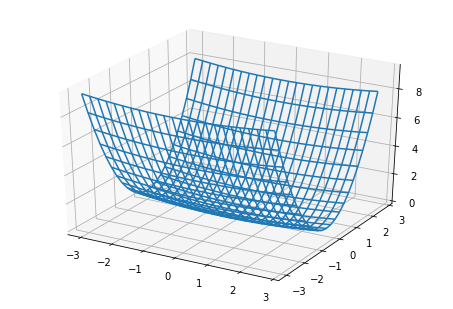

In [67]:
plotSampleFunc()

In [68]:
def numerical_gradient(f, x):
    h = 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    
    return grad

In [69]:
def optimize(optimizer):
    params = {}
    params['a'] = np.array([-7.0, 2.0])
    grads = {}
    
    x = np.array([])
    y = np.array([])
    
    for i in range(10000):
        grads['a'] = numerical_gradient(sampleFunc, params['a'])
        optimizer.update(params, grads)
        x = np.append(x, params['a'][0])
        y = np.append(y, params['a'][1])
        
    plt.plot(x, y)

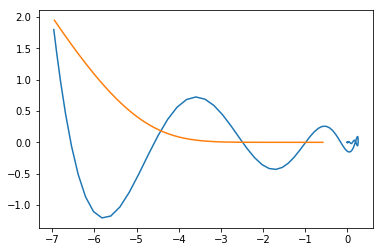

In [70]:
optimize(Momentum())
optimize(AdaGrad())
plt.show()

## 重みの初期値の最適化

重みが大きくなりすぎると過学習が起きる。  
そのため、なるべく重みのパラメータを小さくしたい。  
ただし、重みの値がばらけていないと学習の際に同じ値で更新されてしまう。

### Xavier の初期値
重みの初期値として一般的なディープラーニングのフレームワークで標準的に用いられている。  
各層のアクティベーションを同じ広がりのある分布にすることを目的とする。  
前層のノードの個数をnとした場合、$ \frac { 1 }{ \sqrt { n }  }  $ の標準偏差を持つ分布を使う。
活性化関数が線形であること前提。

![](./xavier.svg)

### He の初期値
ReLUを用いる場合には、ReLU に特化した初期値を用いることが推奨されている。  
前層のノードの数がn個の場合、 $ \sqrt { \frac { 2 }{ n } } $ を標準偏差とするガウス分布を用いる。

In [71]:
# https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/multi_layer_net.py#L50
def __init_weight(self, weight_init_std):
        """重みの初期値設定
        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])


5 層のニューラルネットワーク(各層 100 個のニューロン)で、活性化関数として ReLU を使用して、初期値を std と Xavier と He に変更して損失を求める。

![](./init_compare.png)